# **Final Assigment: Yahoo Answers Topic**

---

# Part 0: Dataset

In this project, we will be using the **Yahoo Topics** dataset for the tasks below.

We’ll start by loading it using the Hugging Face `datasets` library.

This dataset contains a large number of questions and their respective answers in topics such as sports, business & finance, society & culture, science & mathematics, family & relationships, computers & the internet, and more.


In [1]:
!pip install -U datasets fsspec # run this if you run with colab.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

# Convert to pandas DataFrame for easier handling
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
#df = df.rename(columns={"text": "document", "label": "true_label"})

# Show basic info
print(f"Dataset size: {len(df)} documents")
df.head()

README.md:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset size: 1460000 documents


,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


Below are the libraries we will use to deal with this dataset

In [3]:
# run if colab.
!pip install -U datasets transformers evaluate

!pip install nltk
import nltk
nltk.download('stopwords')
!pip install wordcloud

!pip install lime

!pip install -U scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2f38657ad7a60bf8fd7f8ea3ba8e834556f1807c544602effd9c8cb9a6d5ed09
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
# I imported a library that detects the language of the text.
!pip install langdetect
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from collections import defaultdict
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from collections import Counter
import re

from datasets import load_dataset, DatasetDict
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
import evaluate, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import torch, random, os
from datasets import Dataset, DatasetDict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a607af198fa1c6bb569989af091368c03018fec976aae3bf5468f0b190a4bfd8
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


# Part 1: Problem Setup

**Objective**:

The goal of this project is to build and evaluate models for automated topic classification on the Yahoo Answers dataset. This dataset contains user-submitted questions categorized into broad topics. By establishing a baseline performance through random and rule-based classifiers, and reviewing the state of the art, we aim to understand the challenges of this task and prepare for building more sophisticated models in later stages


## Bibliography and SOA


**Main Objective**: The task is a multi-class text classification. We will be classifying topics as it is often conceived a natural first supervised learning task due to its clear label structure and real-world applicability. Additionally, there are multiple research papers available acting as a baseline.


**Business Case**:  In practice, it's common for businesses to receive a large number of customer questions through support channels. These questions can cover a wide variety of topics — from product functionality and billing issues to technical problems and general inquiries. This diversity makes customer service more complex, as each question typically needs to be routed to the appropriate department manually.

A department handling all topics at once would be inefficient because it would slow down response times, overload general support staff, and increase the chance of miscommunication or misrouting. Without this topic-awareness, questions may bounce between departments, leading to customer frustration and operational delays.

By implementing a topic classification system, businesses can automatically categorize incoming queries and send them directly to the relevant team. This allows specialized agents to address issues more quickly and effectively, improving both customer satisfaction and internal workflow efficiency. Only after a question is correctly identified in terms of its topic can it be answered in a relevant and high-quality manner.

**State of the Art**:
Due to the datasets popularity, there have been a lot of attempts in utilizing this text data for classification purposes. This includes different methodologies, from rule-based classification, SVM, Neural Networks and Large Language models. Below are some papers that explore it in different ways, showcasing how different methodologies yield slightly different results and how it got better over time with more suffisticated models:

- Zhang et al. (2015) introduced the Yahoo Answers dataset as part of a suite of large-scale text classification benchmarks. They compared traditional models like n-gram TF-IDF + Logistic Regression against deep neural networks, including character-level CNNs. This work already highlighted the limitations of shallow models and the potential of deep architectures in capturing richer language patterns.
https://arxiv.org/abs/1509.01626


- Kumar et al. (2017) applied hierarchical SVM-based classifiers to Yahoo Answers questions, modeling the structure of categories to improve accuracy over flat classification.
https://www.researchgate.net/publication/224345610_Applying_Question_Classification_to_Yahoo_Answers


- Overall, recent benchmarks on PapersWithCode show that modern models like transformer (BERT, RoBERTa, and DistilBERT) significantly outperform earlier approaches. Fine-tuned RoBERTa-base models can achieve nearly 80% accuracy, compared to ~70% for traditional methods.
https://paperswithcode.com/sota/text-classification-on-yahoo-answers


| Rank | Model             | Accuracy (%) | Paper Title                                                                 | Year |
|------|-------------------|--------------|------------------------------------------------------------------------------|------|
| 1    | BERT-ITPT-FiT     | 77.62        | How to Fine-Tune BERT for Text Classification?                              | 2019 |
| 2    | DRNN              | 76.26        | Disconnected Recurrent Neural Networks for Text Categorization              | 2018 |
| 3    | DELTA (HAN)       | 75.10        | DELTA: A DEep learning based Language Technology plAtform                   | 2019 |
| 4    | EXAM              | 74.80        | Explicit Interaction Model towards Text Classification                      | 2018 |
| 5    | DNC+CUW           | 74.30        | Learning to Remember More with Less Memorization                            | 2019 |
| 6    | ULMFiT (Small data)| 74.30       | Sampling Bias in Deep Active Classification: An Empirical Study             | 2019 |
| 7    | CCCapsNet         | 73.85        | Compositional Coding Capsule Network with K-Means Routing for Text Classification | 2018 |
| 8    | SWEM-concat       | 73.53        | Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms | 2018 |
| 9    | FastText          | 72.30        | Bag of Tricks for Efficient Text Classification                             | 2016 |
| 10   | Seq2CNN (50)      | 55.39        | Abstractive Text Classification Using Sequence-to-convolution Neural Networks | 2018 |


![image.png](attachment:image.png)

**Figure 1:** Accuracy of top models on the Yahoo Answers text classification task. Source: [Papers With Code – Yahoo Answers](https://paperswithcode.com/sota/text-classification-on-yahoo-answers)

## Dataset Description


The dataset used is **Yahoo Answers Topics**, a large dataset (1.4M rows) containing community question and answer pairs across 10 topic categories. Each sample includes a question title, question content, best answer, and a numeric label for the topic.

Below is a summary including dataset size, class distribution, and average lengths of the question and answer texts.

In [ ]:
# Descriptive statistics
dataset_size = len(df)
class_names = train_dataset.features['topic'].names
class_distribution = df['topic'].value_counts().sort_index()
class_counts_named = {class_names[i]: class_distribution[i] for i in range(len(class_names))}

avg_question_length = df['question_content'].apply(lambda x: len(x.split())).mean()
avg_answer_length = df['best_answer'].apply(lambda x: len(x.split())).mean()
avg_question_length_char = df['question_content'].apply(lambda x: len(x)).mean()
avg_answer_length_char = df['best_answer'].apply(lambda x: len(x)).mean()
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()
max_question_length = df['question_content'].apply(lambda x: len(x.split())).max()
max_answer_length = df['best_answer'].apply(lambda x: len(x.split())).max()
missing_questions = df['question_content'].isnull().sum()
missing_answers = df['best_answer'].isnull().sum()

# Print summary
print("Total samples:", dataset_size)
print("Number of classes:", len(class_names))
print("Average question length (words):", round(avg_question_length, 2))
print("Average answer length (words):", round(avg_answer_length, 2))
print("Average question length (characters):", round(avg_question_length_char, 2))
print("Average answer length (characters):", round(avg_answer_length_char, 2))
print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)
print("Maximum question length (words):", max_question_length)
print("Maximum answer length (words):", max_answer_length)
print("Missing questions:", missing_questions)
print("Missing answers:", missing_answers)
print("\nClass distribution:")
for cls, count in class_counts_named.items():
    print(f"{cls}: {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_distribution)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Yahoo Answers Dataset")
plt.tight_layout()
plt.show()


Overall, we have 1 460 000 samples in this dataset. Furhtermore, it is evenly distributed across all 10 classes, with **146,000 samples per class**, making it **balanced** — a desirable property for training classification models without introducing bias toward more frequent classes.

In terms of text statistics:
- The **average question content length** is approximately **22 words**.
- The **average best answer length** is around **59 words**.
- Minimum and maximum word counts range from very short single-sentence questions to long multi-sentence answers (optional to mention if you've calculated them).

This difference in length suggests that answers tend to be significantly more verbose than the questions, which is expected in a Q&A format. The balanced class distribution and large sample size make this dataset well-suited for benchmarking text classification models.

No missing values or duplicates were observed in the provided training split. However, there appears to be some kind of empty string answers and questions, as the minimum answer and question length is 0. Therefore, we filter these out of the dataframe below

Empty questions: 658761
Empty answers: 25606
Minimum question length (words): 1
Minimum answer length (words): 1
Questions with 3 or fewer words: 37678
Answers with 3 or fewer words: 45856


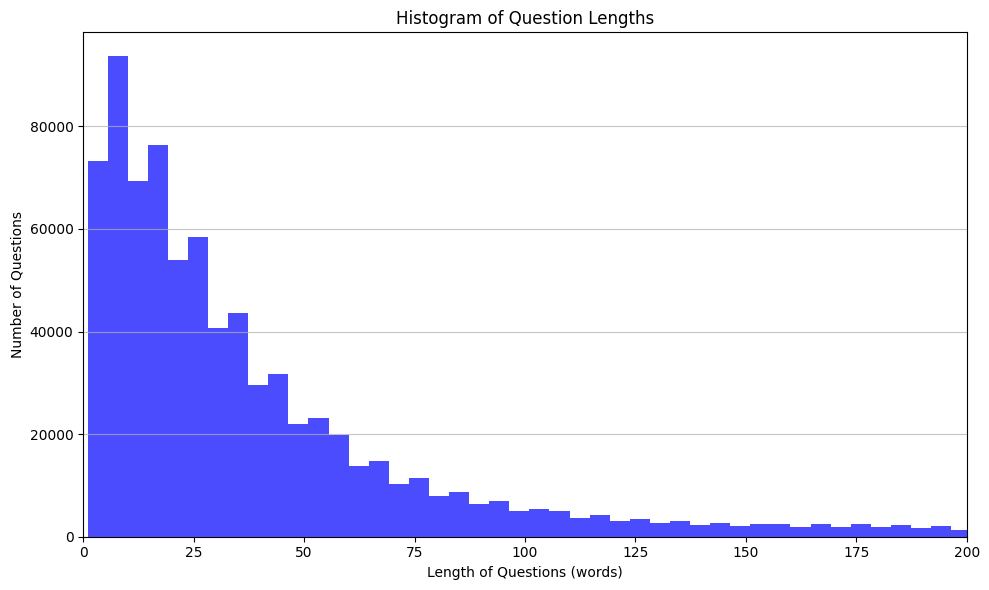

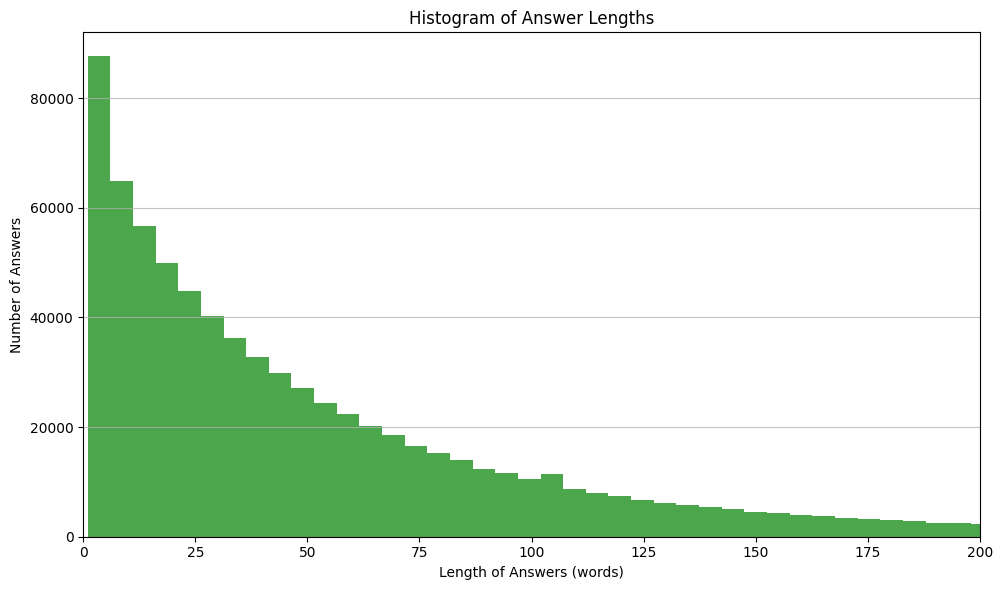

In [6]:
empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

# Check for empty questions and answers again
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()

print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)

short_questions = df['question_content'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Questions with 3 or fewer words: {short_questions}")

# Count answers with 3 or fewer words
short_answers = df['best_answer'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Answers with 3 or fewer words: {short_answers}")


#plot a histogram of the length of the questions
plt.figure(figsize=(10, 6))
plt.hist(df['question_content'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='blue')
plt.xlabel("Length of Questions (words)")
plt.ylabel("Number of Questions")
plt.title("Histogram of Question Lengths")
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()
#plot a histogram of the length of the answers
plt.figure(figsize=(10, 6))
plt.hist(df['best_answer'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='green')
plt.xlabel("Length of Answers (words)")
plt.ylabel("Number of Answers")
plt.title("Histogram of Answer Lengths")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.xlim(0, 200)
plt.show()

We can see that we have quite a few cases where questions or answers are extremely short — specifically, 37,678 questions and 45,856 answers contain three words or fewer. After filtering out completely empty entries, the minimum question and answer lengths increased to 1 word. However, some of these very short entries likely still contain low-information or meaningless text (e.g., "help", "why?", "okay").

Despite this, we choose not to remove these cases, for a few reasons:

- First, their presence reflects the natural noise of user-generated content, which models in production settings are likely to encounter.

- Second, the dataset remains large and balanced, so these outliers are unlikely to skew the overall learning process.

- Finally, short or vague questions may still contain subtle topic cues (e.g., a question like "Windows issue" may still be clearly technical).

For these reasons, we retain the short samples and proceed with the cleaned dataset, accepting a small degree of noise as part of the task's inherent complexity.

Finally, we will check which languages we are dealing with! It can be helpful when it comes to preprocessing techniques or stopword removals!

For analytical purposes to check the language distribution, we will use a subset of only 100 000 samples to avoid high computational times. We will also use this subset for the wordcloud below!

In [7]:
# Function detect language
def safe_detect(text):
    try:
        return detect(text) if isinstance(text, str) and text.strip() else "unknown"
    except:
        return "error"
#create new column
sample_df = df.sample(100000, random_state=42)
sample_df["lang"] = sample_df["question_content"].apply(safe_detect)
language_counts = print(sample_df["lang"].value_counts())


print(language_counts)


lang
en       94960
fr         627
af         545
error      418
nl         348
cy         277
it         264
de         257
no         224
so         217
ca         193
tl         184
da         174
pt         139
ro         135
es         125
id         123
et         107
vi          97
pl          84
sv          66
hr          62
sw          61
fi          50
tr          46
sq          45
sl          42
hu          38
sk          32
lt          21
cs          19
lv          10
ar           4
ru           2
he           1
uk           1
el           1
zh-cn        1
Name: count, dtype: int64
None


In [8]:
#POL NOTE: I think we  should remove the rows with other languages that are not English.

We can see that our corpus is predominantly in English, which means our classifier will likely also learn English language patterns.
We acknowledge that there is the possibility to filter to only English content to reduce the noise. Nevertheless, we will carry on including everything for now and potentially adress if deemed necessary.

## Random Classifier Performance

A random classifier assigns a class label to each sample by randomly selecting from the available topic classes.
Random means we basically toss a coin, so if we have 1 class and 1 sample it will be correct 50% of the tosses. This can also be calculated for many samples. As long as the balance of the classes remain the same. If we had 1 sample and for classes it would be 25%.

Since the Yahoo Answers dataset is balanced across these 10 classes, the expected performance of such a classifier is:

$
\frac{1}{10} = 0.10 \text{, so } 10\%
$

We will confirm this through a simple simulation below.

In [9]:
# Simulate random predictions
num_samples = len(df)
num_classes = 10
random_preds = np.random.randint(0, num_classes, size=num_samples)

# True labels
true_labels = df['topic']

# Accuracy of random predictions
random_accuracy = accuracy_score(true_labels, random_preds)
print(f"Simulated Random Classifier Accuracy: {random_accuracy:.4f}")

Simulated Random Classifier Accuracy: 0.0997


We can confirm that our calculation is correct!

## Baseline Implementation

To develop a rule-based baseline classifier, we first generated word clouds for each topic class using the subset of the training data. By visually inspecting the most prominent words, we manually selected a list of distinctive keywords for each class that capture its semantic domain. Importantly, there are some words that should be ignored or added to the stopwords as they appear in multiple topics (i.e. "now" appears in all wordclouds).

Additionally, we include some intuition baswed words (e.g., "doctor", "medicine" for Health, or "movie", "band" for Entertainment & Music) which should clearly define the corresponding topics.

We then implemented a simple keyword-matching function that assigns a class label if any of the keywords appear in the input question. After that, we analyze with lime if our intuition is right and improve if it's necessary.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


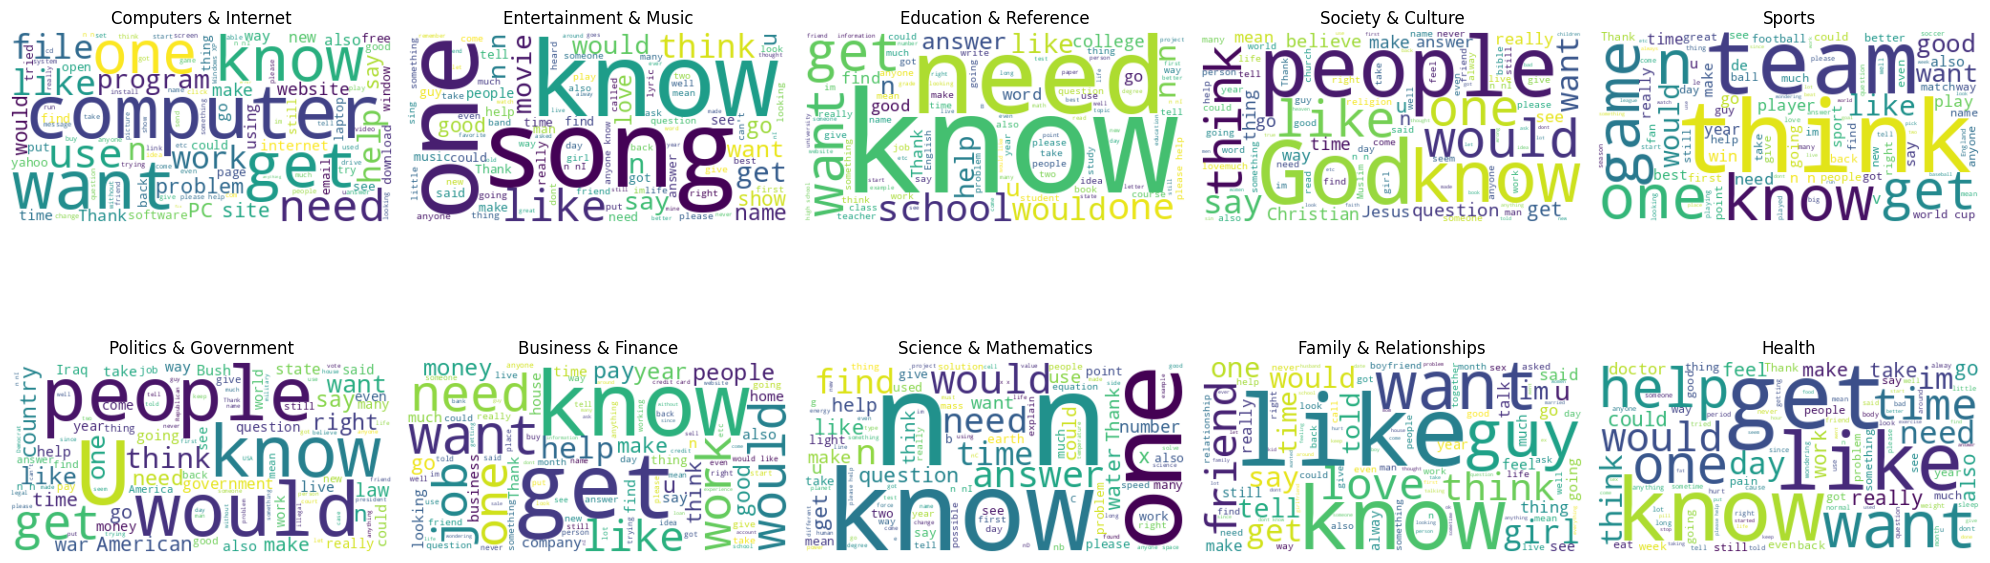

In [10]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Get label names from above
label_names = class_names

# Aggregate question content by topic
label_text = defaultdict(str)
for text, label in zip(sample_df['question_content'], sample_df['topic']):
    label_text[label] += ' ' + text

# Generate and plot word clouds
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for idx, (label, text) in enumerate(label_text.items()):
    wordcloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_words=100
    ).generate(text)

    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].set_title(f"{label_names[label]}", fontsize=12)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Define keywords for each class
rules = {
    "Health": ["day", "time", "doctor", "medicine", "pain", "symptom"],
    "Computers & Internet": ["using", "problem", "windows", "wifi", "laptop", "computer", "browser"],
    "Politics & Government": ["law", "say", "country", "election", "government", "president", "senate"],
    "Sports": ["think", "game", "score", "team", "football", "league"],
    "Science & Mathematics": ["one", "question", "math", "science", "chemistry", "physics", "equation"],
    "Education & Reference": ["school", "college", "university", "study", "homework"],
    "Business & Finance": ["work","money", "business", "finance", "investment", "stock"],
    "Entertainment & Music": ["movie", "music", "concert", "band", "album"],
    "Family & Relationships": ["guy", "answer", "marriage", "relationship", "family", "friend", "love"],
    "Society & Culture": ["people", "god", "culture", "world", "travel"],
}

name_to_id = {name: idx for idx, name in enumerate(label_names)}

print(name_to_id)
# Simple classifier
def classify_rule_based(text):
    text = text.lower()
    for label, keywords in rules.items():
        if any(word in text for word in keywords):
            return name_to_id[label]
    # If no keywords match, return a fallback class, randomly assigning a class 0-9
    random_class = np.random.choice(list(rules.keys()))
    return name_to_id[random_class]
# Apply the rule-based classifier
df['predicted_label'] = df['question_content'].apply(classify_rule_based)
# Calculate accuracy
accuracy = accuracy_score(df['topic'], df['predicted_label'])
print(f"Rule-based Classifier Accuracy: {accuracy:.4f}")




{'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3, 'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7, 'Family & Relationships': 8, 'Politics & Government': 9}
Rule-based Classifier Accuracy: 0.1996


Accuracy is about **20%**, which is quite a bit better than the odds! Let's check the most common words in false predictions to improve this a bit.

### Improvement and Final Accuracy

In [12]:
# Choose a class to analyze
target_class_id = name_to_id["Health"]
target_class_name = label_names[target_class_id]

# Split into true positives and false positives
true_positives = df[(df['predicted_label'] == target_class_id) & (df['topic'] == target_class_id)]
false_positives = df[(df['predicted_label'] == target_class_id) & (df['topic'] != target_class_id)]

def get_word_counts(series):
    counter = Counter()
    for text in series.dropna():
        tokens = re.findall(r'\b\w+\b', text.lower())
        counter.update(tokens)
    return counter

# Get word frequencies
tp_counts = get_word_counts(true_positives['question_content'])
fp_counts = get_word_counts(false_positives['question_content'])

# Words unique to true or false positives
unique_tp_words = {w: f for w, f in tp_counts.items() if w not in fp_counts}
unique_fp_words = {w: f for w, f in fp_counts.items() if w not in tp_counts}

# Top 20 for each
print(f"\nMost distinctive words in TRUE POSITIVES for '{target_class_name}':")
print(sorted(unique_tp_words.items(), key=lambda x: x[1], reverse=True)[:20])

print(f"\nMost distinctive words in FALSE POSITIVES predicted as '{target_class_name}':")
print(sorted(unique_fp_words.items(), key=lambda x: x[1], reverse=True)[:20])


Most distinctive words in TRUE POSITIVES for 'Health':
[('calorie', 98), ('heartburn', 63), ('wellbutrin', 58), ('bloating', 53), ('lightheaded', 41), ('yasmin', 37), ('dandruff', 36), ('gerd', 34), ('sunscreen', 32), ('klonopin', 32), ('ointment', 31), ('l5', 29), ('vertigo', 28), ('gout', 27), ('lumbar', 26), ('lyme', 26), ('tonsilitis', 26), ('scoliosis', 25), ('achy', 25), ('ecg', 25)]

Most distinctive words in FALSE POSITIVES predicted as 'Health':
[('islam', 714), ('immigrants', 663), ('troops', 564), ('password', 484), ('democrats', 461), ('evolution', 423), ('israel', 419), ('federal', 412), ('jews', 409), ('worship', 396), ('congress', 394), ('liberal', 374), ('explorer', 362), ('illegals', 359), ('leader', 352), ('ram', 349), ('wwe', 345), ('printer', 337), ('weapons', 332), ('documents', 322)]


With this, we can see which words are the most important for true positives and false positives and adapt our rule based classifier to include these terms correctly.



In [13]:
rules["Politics & Government"].extend([
    "immigrants", "democrats", "congress", "liberal", "federal",
    "illegals", "leader", "weapons", "troops"
])

rules["Society & Culture"].extend([
    "islam", "jews", "worship", "israel", "nations", "evolution"
])

rules["Computers & Internet"].extend([
    "password", "explorer", "printer", "ram"
])

rules["Entertainment & Music"].append("wwe")

rules["Health"].extend([
    "doctor", "medicine", "pain", "symptom", "health", "hospital", "treatment",
    "illness", "disease", "calorie", "heartburn", "ortho", "bloating",
    "lightheaded", "yasmin", "gerd", "dandruff", "klonopin", "ointment",
    "sunscreen", "l5", "lyme", "gout", "scoliosis", "lumbar", "achy",
    "tonsilitis", "cyclen", "monistat"
])

df['predicted_label'] = df['question_content'].apply(classify_rule_based)
# Calculate accuracy
accuracy = accuracy_score(df['topic'], df['predicted_label'])
print(f"Rule-based Classifier Accuracy: {accuracy:.4f}")


Rule-based Classifier Accuracy: 0.2123


We can see how we improved the accuracy by about 1.5%, which is a slight improvement but considering we only did the improvement by analysing the FP and TP for the `Health` class it's quite decent.
We will not be applying this method to all topics to keep this report short and precise but we admit that there is more potential by doing something like it in this simple classifier.

We thus acknowledge this classifier with **21.21%** accuracy as baseline and shall now focus our work on further models to see if we can improve this in a smarter way.

$
\text{Baseline Classifier Accuracy} = 0.2124 \text{, so } 21.21\%
$


# Part 2: Data Scientist Challenge

In this section, we shall explore different techniques to enhance model performance with limited labeled data. We shall start with a simple fine-tuned BERT model below.

## a.

### Tokenize and Setup


We cannot train our model on words. For this reason, we tokenize our input below. Overall, we convert each word into a number and get a vector of token IDs that the BERT model understands. Each question is transformed into a sequence of fixed-length integers, where each integer represents a word or subword token.

We also pad the sentences, based on the max_length=128 setting, to ensure that every input sequence has the same length. We chose max length of 128 because we saw above that the average question length is only about 22 words, which means with 128 we preserve most of the semantic information while at the same time don't use up too much computational power. Altough there are some extreme cases of lengths being 900, these are extreme cases so 128 shall suffice for our purposes.


Thus, the final dataset contains will three main columns: input_ids, attention_mask, and labels

In [5]:
model_ckpt   = "bert-base-uncased"   # ✔️ swap for "microsoft/MiniLM-L6..." if you need something lighter
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [6]:
# Create a small 32-example training set (32-shot learning)
#train_subset = train_dataset.shuffle(seed=42).select(range(32))

# Keep the original test set for evaluation
dataset = DatasetDict({
    "train": train_dataset.shuffle(seed=42).select(range(32)),
    "test": train_dataset.select(range(10000)) #reasonable size for eval
})
observation_training =train_dataset.shuffle(seed=42).select(range(32)) # we are going to use it for later.
# Tokeniser -------------------------------------------------------------------
tok = AutoTokenizer.from_pretrained(model_ckpt)


text = dataset['train'][1]['question_content']
print(text)
tokens = tok.tokenize(text, add_special_tokens=True)
print("length of tokens: ", len(tokens))
print(tokens)
token_ids = tok.convert_tokens_to_ids(tokens)
print("length of token_ids: ", len(token_ids))
print(token_ids)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Bill Clinton was an adulterer. He undermined our copyright laws until 2019.
length of tokens:  19
['[CLS]', 'bill', 'clinton', 'was', 'an', 'adult', '##ere', '##r', '.', 'he', 'undermine', '##d', 'our', 'copyright', 'laws', 'until', '2019', '.', '[SEP]']
length of token_ids:  19
[101, 3021, 7207, 2001, 2019, 4639, 7869, 2099, 1012, 2002, 25174, 2094, 2256, 9385, 4277, 2127, 10476, 1012, 102]


In [7]:
# Tokeniser -------------------------------------------------------------------
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")
# Make sure the format call is complete


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [8]:
len(dataset["train"])

32

In [9]:
dataset["train"]

Dataset({
    features: ['id', 'labels', 'question_title', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32
})

In [10]:
#POL: For later use I want to see the comparation of the embeddings, before and afer the finetuning, that is why I define this function:
def get_cls_embeddings(model, hf_dataset):
    """
    Given a HuggingFace model and a Dataset split (e.g. train_dataset),
    returns two numpy arrays:
      - embeddings: shape (N, hidden_size), where hidden_size=768 for BERT.
      - labels:     shape (N,)
    """
    model.eval()
    all_embs  = []
    all_labels = []

    for example in tqdm(hf_dataset, desc="Extracting embeddings"):
        # Each example already has: example["input_ids"], example["attention_mask"], example["token_type_ids"]
        input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
        token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                output_hidden_states=True,
                return_dict=True
            )
            # last hidden layer: [batch_size=1, seq_len, hidden_dim]
            last_hidden  = outputs.hidden_states[-1]
            cls_emb      = last_hidden[:, 0, :]   # take [CLS] token → shape [1, hidden_dim]

        all_embs.append(cls_emb.cpu().numpy().squeeze())      # shape (hidden_dim,)
        all_labels.append(example["labels"])                  # integer in [0 .. num_labels-1]

    return np.vstack(all_embs), np.array(all_labels)

### Building the model


After tokeniizng, we can succesfully build the model as requested in the task.

For this, we will load the pretrained `bert-base-uncased`automatically using huggingsface transformers library.
Pareameter and set up wise, we stick to the same set up used in the lecture but only adjust the metrics to work with multi-class classification

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
#WE SAVE THE EMBEDDINGS BEFORE THE FINE TUNING.
embeddings_before, labels = get_cls_embeddings(model, dataset['train'])

Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-10-d4cfd177aa20>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
<ipython-input-10-d4cfd177aa20>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
<ipython-input-10-d4cfd177aa20>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0

In [17]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

In [18]:
trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [19]:
#Train the Model
train_output = trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,1.245900,2.309969,0.074200,0.041743,0.092443
2,1.250300,2.306021,0.081600,0.112501,0.094235
3,1.218700,2.262126,0.217800,0.107556,0.103220
4,1.184200,2.263592,0.224300,0.115355,0.103891
5,1.152900,2.328995,0.097000,0.098182,0.097253
6,1.113800,2.328995,0.097000,0.098182,0.097253


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

We can push it to Huggingface so that we can load it from there:

In [22]:
from huggingface_hub import notebook_login
notebook_login()


In [23]:
trainer.push_to_hub("yahoo-bert-32shot")


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RosaMelo/yahoo-bert-32shot/commit/540ee1f42238d999f9176693fda2226e16ceadba', commit_message='yahoo-bert-32shot', commit_description='', oid='540ee1f42238d999f9176693fda2226e16ceadba', pr_url=None, repo_url=RepoUrl('https://huggingface.co/RosaMelo/yahoo-bert-32shot', endpoint='https://huggingface.co', repo_type='model', repo_id='RosaMelo/yahoo-bert-32shot'), pr_revision=None, pr_num=None)

## Performance Analysis

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("otausendschoen/yahoo-bert-32shot") #remove string to train from scratch


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In the end, only 10 epochs were performed because early stopping kicked in. We can get an overview of the training and check if all went smoothly by checking the logs:

In [20]:
logs = trainer.state.log_history
logs

[{'loss': 1.2459,
  'grad_norm': inf,
  'learning_rate': 2e-05,
  'epoch': 1.0,
  'step': 1},
 {'eval_loss': 2.309969425201416,
  'eval_accuracy': 0.0742,
  'eval_precision': 0.041743439936616375,
  'eval_recall': 0.092443235972128,
  'eval_runtime': 14.119,
  'eval_samples_per_second': 708.268,
  'eval_steps_per_second': 7.083,
  'epoch': 1.0,
  'step': 1},
 {'loss': 1.2503,
  'grad_norm': 3.8240342140197754,
  'learning_rate': 2e-05,
  'epoch': 2.0,
  'step': 2},
 {'eval_loss': 2.306020736694336,
  'eval_accuracy': 0.0816,
  'eval_precision': 0.11250100405835876,
  'eval_recall': 0.09423470330816305,
  'eval_runtime': 13.6919,
  'eval_samples_per_second': 730.357,
  'eval_steps_per_second': 7.304,
  'epoch': 2.0,
  'step': 2},
 {'loss': 1.2187,
  'grad_norm': 3.9407284259796143,
  'learning_rate': 1.8e-05,
  'epoch': 3.0,
  'step': 3},
 {'eval_loss': 2.2621264457702637,
  'eval_accuracy': 0.2178,
  'eval_precision': 0.10755613979491108,
  'eval_recall': 0.10321979504979364,
  'eval_r

**Loss Plot**

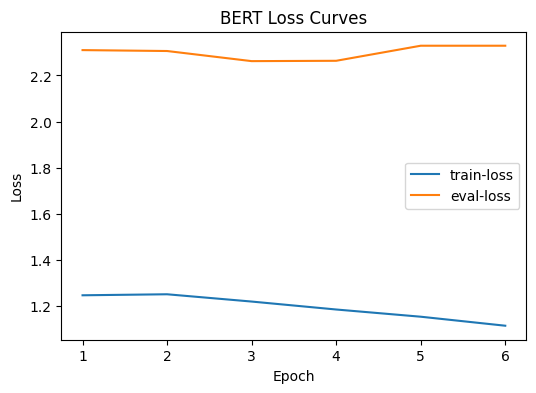

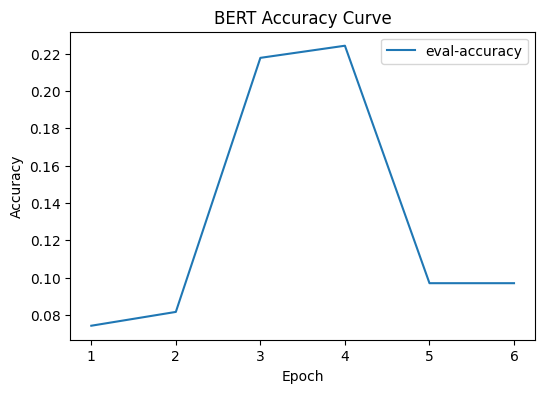

In [21]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()




Interestingly, 10 epochs seem to be sufficient as we reach early stopping after epoch 7 anyways. This is also why we don't see epoch 8, 9 and 10 appearing in the logs or in the plot. Observing the loss plot in detail, we can notice a few things:

- The training loss decreases slightly but steadily, from about 1.22 to 1.15. This indicates there seems to be some kind of fitting to the training data. The small change in loss is expected due to the tiny dataset.
- Howevr, the evaluation loss decreases slightly in the beginnning but then fattens and rises again - We are then early stoppi8ng to prevent more harmful adjustments of the parameters. Seems like we are **overfitting**! The 32 examples we have probably do not (evenly) represent all 10 classes. Let's check this out with a confusion matrix:


**Confusion Matrix**

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


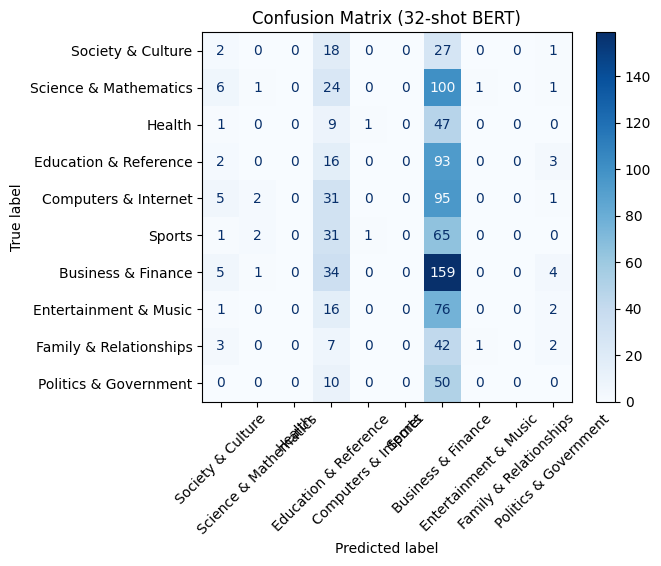

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)

# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
label_names = train_dataset.features['topic'].names

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


This confirms our suspicion:

The model over relies on a few classes like `Politics & Government` which lead to poor generalization.
For example, we see how 43 out of 62 `Society & Culture` got predicted as  `Politics & Government`and 92 out of 109 `Science & Mathematics` got also predicted as  `Politics & Government`.


We can further analyze this with the classification report below.

**Report**

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))


                        precision    recall  f1-score   support

     Society & Culture       0.08      0.04      0.05        48
 Science & Mathematics       0.17      0.01      0.01       133
                Health       0.00      0.00      0.00        58
 Education & Reference       0.08      0.14      0.10       114
  Computers & Internet       0.00      0.00      0.00       134
                Sports       0.00      0.00      0.00       100
    Business & Finance       0.21      0.78      0.33       203
 Entertainment & Music       0.00      0.00      0.00        95
Family & Relationships       0.00      0.00      0.00        55
 Politics & Government       0.00      0.00      0.00        60

              accuracy                           0.18      1000
             macro avg       0.05      0.10      0.05      1000
          weighted avg       0.08      0.18      0.08      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Firstly, the overaall accuracy is as depicted in the plot.
- This is only slightly above the **random baseline** 10%. It furthermore confirms the inability to generalize.
- The high recal of 0.79 shows that the model predicts `Politics & government` for almost everything as we discussed earlier.
- We also have zero precision and recall for many other classes, indicating that some classes are never predicted at all.
  

Label counts: 32
[4, 2, 0, 2, 2, 3, 4, 2, 7, 6]


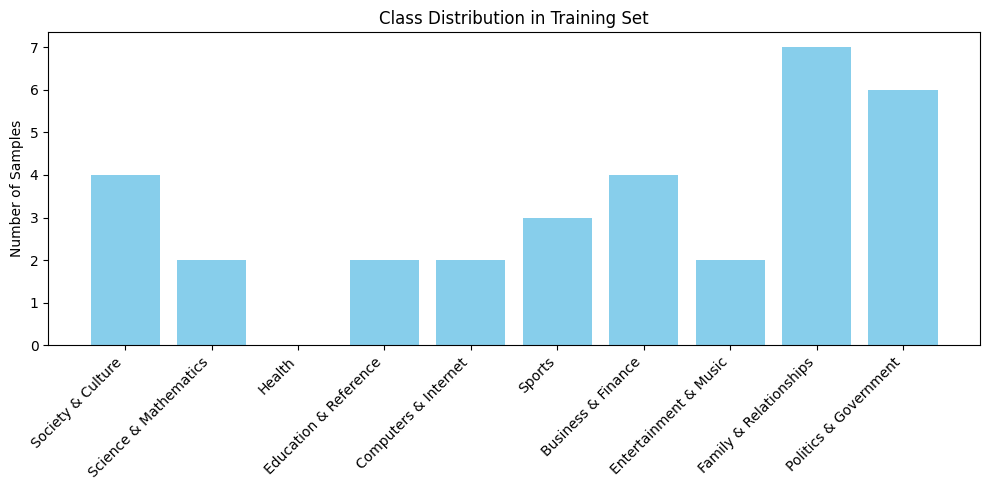

In [24]:
labels_list = dataset["train"]["labels"].tolist()

print("Label counts:", len(labels_list))
label_counts = Counter(labels_list)
counts = [label_counts[i] for i in range(len(label_names))]
print(counts)
plt.figure(figsize=(10, 5))
plt.bar(label_names, counts, color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

We can clearly see that the classes `Family & Relationship` and `Politics & Government` are overrepresented, and `health` is not present at all! Thus, the model has no chance to learn about `Health`!

To adress this, we will train the model again with the same parameters but using a stratified traiing dataset.
This will be done in the section below.

---
POL

In [19]:
dataset["train"]

Dataset({
    features: ['id', 'labels', 'question_title', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32
})

In [25]:
model_finetuned = model

# EXTRACT EMBEDDINGS AFTER FINE‐TUNING
embeddings_after, labels_after = get_cls_embeddings(model_finetuned, dataset['train'])

Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-10-d4cfd177aa20>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
<ipython-input-10-d4cfd177aa20>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
<ipython-input-10-d4cfd177aa20>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0

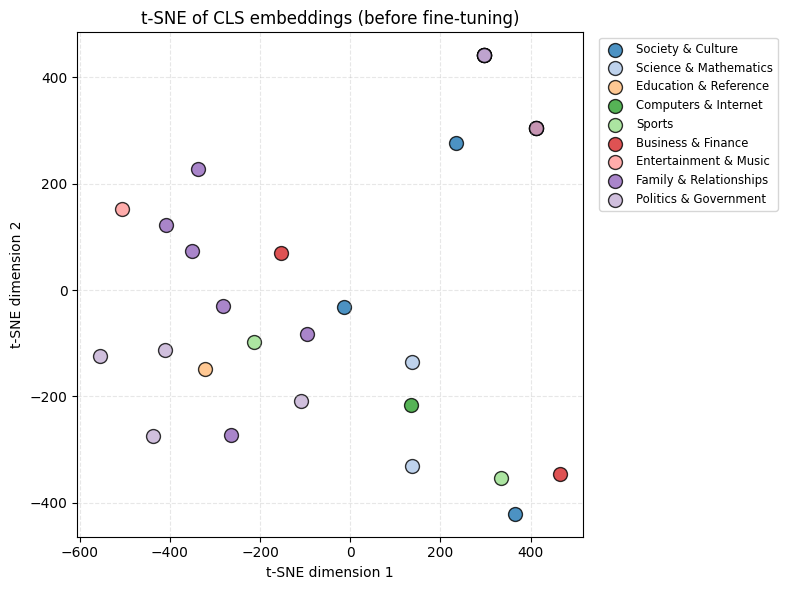

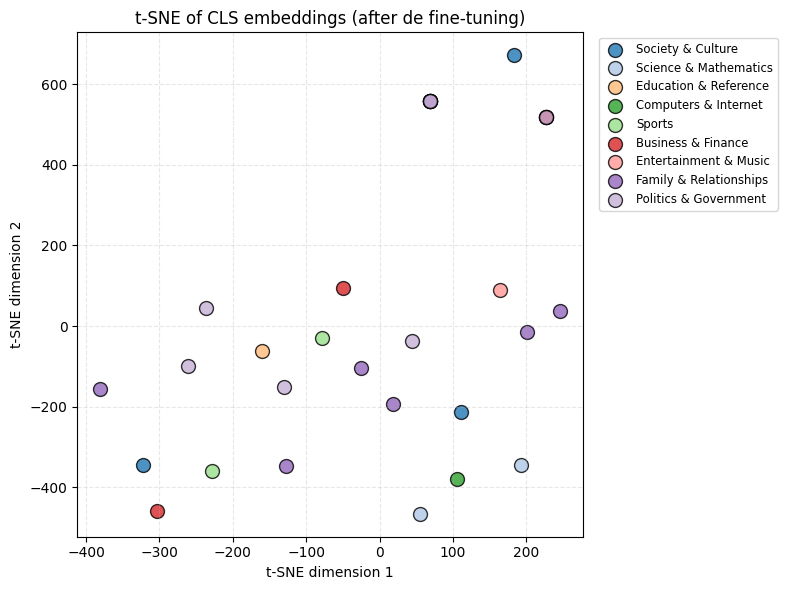

In [40]:
# Reduce  2D with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)

X2_before = tsne.fit_transform(embeddings_before)  # (32, 2)
X2_after  = tsne.fit_transform(embeddings_after)   #  (32, 2) N=32

def plot_tsne_2d(X2, labels, label_names, title):
    """
    X2: array of  forma (N, 2)
    labels: array (N,)
    label_names: list of the names
    title: title for the plot
    """
    plt.figure(figsize=(8, 6))

    #generate plots
    num_classes = len(label_names)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i) for i in range(num_classes)]


    for class_id in range(num_classes):
        idxs = np.where(labels == class_id)[0]
        if len(idxs) == 0:
            continue
        plt.scatter(
            X2[idxs, 0],
            X2[idxs, 1],
            c=[colors[class_id]],
            label=label_names[class_id],
            s=100,
            alpha=0.8,
            edgecolors="k"
        )

    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot before and plot afer FT
plot_tsne_2d(
    X2_before,
    labels,
    label_names,
    title="t-SNE of CLS embeddings (before fine-tuning)"
)

plot_tsne_2d(
    X2_after,
    labels,
    label_names,
    title="t-SNE of CLS embeddings (after de fine-tuning)"
)


t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality-reduction technique that projects high-dimensional data into two or three dimensions by modeling pairwise similarities: it converts distances into probabilities, preserves local neighborhood structure, and uses a heavy-tailed Student's t-distribution in the low-dimensional space to prevent points from crowding together.

We only use it to plot the embeddings to a 2D space where we can visually see how the fine-tuning afect to the embeddings fo the 32 labeled examples.

From this plot, it's not immediately obvious what the model has learned, especially given that it was trained on only 32 examples. However, when using the cross-entropy loss function, we would expect the embeddings to become approximately **linearly separable by class**. In the visualization, we only see 24 points instead of 32—not because data is missing, but because several embeddings might overlap completely in the 2D space. Why does this happen? A likely explanation is that many of the input questions we tokenized are either very similar or even empty, which results in nearly identical embeddings regardless of class. This undermines the model's ability to learn meaningful class distinctions. Let's Take a deep observation on the training DATA.

In [60]:
ep_df = observation_training.to_pandas()
print(ep_df[['topic', 'question_content']])
print(label_names)

    topic                                   question_content
0       9  We have searched and cannot find a ship that s...
1       9  Bill Clinton was an adulterer. He undermined o...
2       0                                                   
3       4  I'm trying to make a cell that has a list of o...
4       1  Hi. I know how Bayesian Statistical inference ...
5       8  I've been dating a man from Mexico.  He's a gr...
6       0  Yea, I am only 16 and I have a long time (hope...
7       9                      http://www.enewsreference.com
8       8                                                   
9       6  Especially when you really like the people you...
10      8                                        plz be kind
11      8                       hint hint im  in highskoool!
12      8  to talk about whatever you want.  e mail addre...
13      5           anyone know of any good bars, etc?  Thx.
14      5  I am reposting this question so i can get mor ...
15      0  I'm intereste

As expected, 11 out of the 32 training examples we used have an empty or nearly empty 'question_content' field. This aligns with the suboptimal results we're observing. Given the already limited size of our training set, having over a third of the examples contain no meaningful input severely impacts the model's ability to learn. These empty examples likely produce very similar or indistinguishable embeddings—regardless of their class labels—which introduces noise into the training process. As a result, the model receives conflicting signals, making it harder to learn class-specific representations and leading to poor generalization performance. In low-data regimes like few-shot learning, data quality is just as important as quantity, and including empty or low-information inputs can be especially damaging.





*  'Society & Culture' --> 2 empty (2/4)
* 'Science & Mathematics' -->non empty (0/2)
*  'Health'. --> non empty (0/0)
*  'Education & Reference'. --> 1 empty (1/2)
* 'Computers & Internet' --> 1 empty (1/2)
*   'Sports'. --> 1 empty (1/3)
* 'Business & Finance' --> 2 empty (2/4)
* 'Entertainment & Music' --> 1 (1/2)
* 'Family & Relationships' -->1 (1/7)
*  'Politics & Government --> 2 (2/6)



4, 2, 0, 2, 2, 3, 4, 2, 7, 6

### 32 Shot 2.0 (stratified 32 samples)

Since we reuse most of the code from above, we skip explanations and put the stratification in one chunk and all the rest into another.

In [30]:
from datasets import Dataset, DatasetDict
import pandas as pd
from sklearn.model_selection import train_test_split

# Perform stratified sampling (32 samples)
stratified_df, _ = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)

# Convert back to Hugging Face Dataset
stratified_train_dataset = Dataset.from_pandas(stratified_df)

# Re-wrap everything into a DatasetDict
dataset = DatasetDict({
    "train": stratified_train_dataset,
    "test": test_dataset.select(range(10000))
})


In [31]:
# Tokeniser -------------------------------------------------------------------
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
#train_output = trainer.train("yahoo-bert-32shot_strat")#remove string to train from scratch
train_output = trainer.train(model)
trainer.push_to_hub("yahoo-bert-32shot_strat")


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Can't find a valid checkpoint at yahoo-bert-32shot_strat

In [ ]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)

# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
label_names = train_dataset.features['topic'].names

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


Interestingly, this time the model runs through all 10 epochs without triggering early stopping. Looking at the updated loss plot, we can observe the following improvements:

- The training loss again decreases steadily, now from about 1.20 to 1.12, indicating consistent learning. There are no noisy jumps or instability across epochs.

- Unlike before, the evaluation loss does not increase sharply after a few epochs. Instead, it decreases slightly and then flattens out — suggesting improved generalization.

- This is likely due to better coverage of all 10 classes in the training set. The model no longer overfits as aggressively to a small set of dominant labels.

Overall, the loss curves now reflect a more stable and effective learning process, even with just 32 stratified examples.


Also, the confusion matrix looks significantly different:
While there is still a tendency toward some dominant classes, this distribution is a clear step forward from the earlier imbalance!

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))


From the report, we can see:

- The overall accuracy increased from **11% to 19%**, which is quite significant given that we're still operating in the 32-shot setting.

- Most notably, classes that previously had 0.00 precision or recall now show up with small but non-zero scores.
- Some classes still underperform (e.g., Health, Sports), but this may reflect inherent difficulty or overlapping vocabulary.

**NOTE** MAYBE WE SHOULD ALSO ANALZE THE PREDICTIONS (e.g. LIME AND SO ON), NOT SURE THOUGH

## b) DATA AUMENTATION:


?

## c) Zero Shot Learning with LLM.
I will ose the model llama.3.2 to classify.

In [ ]:

import requests
import time
import copy
API_URL = 'http://127.0.0.1:11434/api/generate'
MODEL_NAME = 'llama3.2:latest'

def classify_text_with_llm(text, topics):
    topics_str = ', '.join(topics)
    prompt = (
        f"Classify the following text into one of the following topics: {topics_str}.\n\n"
        f"Text:\n{text}\n\n"
        f"Your answer should be just one of the topic names in the SAME FORMAT. No explanation."
    )

    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }

    try:
        response = requests.post(API_URL, json=payload)
        response.raise_for_status()
        result = response.json().get("response", "").strip()
        return result
    except requests.RequestException as e:
        print("API error:", e)
        return "Unknown"

def classify_dataset_column(dataset, column_to_classify, topics, sleep_time=0.2):
    new_dataset = copy.deepcopy(dataset)
    predictions = []

    for idx, example in enumerate(new_dataset):
        text = example[column_to_classify]
        prediction = classify_text_with_llm(text, topics)
        predictions.append(prediction)
        print(f"[{idx+1}/{len(new_dataset)}] → {prediction}")
        time.sleep(sleep_time)  # avoid overloading the API

    # Add new column
    new_dataset = new_dataset.add_column("predicted_topic", predictions)
    return new_dataset

We are going to use only 10000 rows of the test dataset. To be consisten with the evaluation metrics used in the other cases, and to reduce the computational time, as we are running this LLM locally, and it has to do 10000 iterations to classift all the data.


In [ ]:
#this code takes 1:30 hours to run

topics = train_dataset.features['topic'].names
print(topics)

full_dataset = load_dataset("yahoo_answers_topics", split="train")

random_subset = full_dataset.shuffle(seed=42).select(range(10000)) #We are going to take

classified_dataset = classify_dataset_column(random_subset, column_to_classify="question_content", topics=topics)

# Preview
classified_dataset.to_csv("ZeroShotClassification.csv", index=False)

### d. Data Generation with LLM
We will use the model llama3.2:latest that has 3B parameters, because it is instruction-tuned (meaning it can follow prompts that specify a task), relatively lightweight for a large model.Unlike larger models, it can be run on accessible hardware such as the GPUs provided in Google Colab Pro. Or even you can download it locally with Ollama, and use it without the need of using an API, that might lead to longer computational times.
We will generate 2000 new questions for each topic. And then we wil have to preprocess them, as this model, Some times may fail.

This is a very delicate part, as it is widely known that the quality of a dataset largely impacts the performance of the model it is fed to.
It is worth mentioning that relying on a large language model to generate questions in-
troduces potential limitations. Since all training questions follow the linguistic patterns
and styles of the LLaMA-generated prompts, the fine-tuned model may underperform
during inference, when faced with human-written queries that differ in structure, tone,
or specificity.

In [ ]:
#This coda
import requests
import pandas as pd
import time

API_URL = 'http://127.0.0.1:11434/api/generate'
MODEL_NAME = 'llama3.2:latest'
NUM_QUESTIONS = 1000 # number of questions to generate per topic

#The topics:
topics = train_dataset.features['topic'].names
print(topics)

def generate_question(topic):
    prompt = f"Generate one interesting and unique question about the topic: {topic}. Avoid extra information, your answer should be a single question without any additional context or explanation. The average lenght of the question should be around 20 words."
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(API_URL, json=payload)
        response.raise_for_status()
        return response.json().get("response", "").strip()
    except requests.RequestException as e:
        print("Error:", e)
        return ""

# Collect all questions in a DataFrame
all_data = []

for topic in topics:
    print(f"Generating questions for topic: {topic}")
    for i in range(NUM_QUESTIONS):
        question = generate_question(topic)
        if question:
            all_data.append({"topic": topic, "question": question})
        time.sleep(0.2)  # Optional: avoid overloading the server

# Convert to DataFrame
df = pd.DataFrame(all_data)
df.to_csv("questions_dataset.csv", index=False)
print("Dataset saved as questions_dataset.csv")

['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']
Generating questions for topic: Society & Culture
Generating questions for topic: Science & Mathematics
Generating questions for topic: Health
Generating questions for topic: Education & Reference
Generating questions for topic: Computers & Internet
Generating questions for topic: Sports
Generating questions for topic: Business & Finance
Generating questions for topic: Entertainment & Music
Generating questions for topic: Family & Relationships
Generating questions for topic: Politics & Government
Dataset saved as questions_dataset.csv
